# Part 1: EXPLORATORY DATA ANALYSIS

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# load in data
df = pd.read_csv('data/ufc-master.csv')

In [3]:
# preview data
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Light Heavyweight,MALE,5,0,1,0,3.42,0.59,0.7,0.24,1.00,4,2,11,0,0,0,1,4,0,0,5,Orthodox,198.12,208.28,205,3,0,0,3.95,0.48,0.1,0.61,0.36,4,8,43,1,0,0,2,11,0,0,13,Orthodox,187.96,193.04,205,37,29,-3,1,0,-8,-6,-32,-1,-7,0,10.16,15.24,-8,-0.53,0.6,-0.37,1,1,10.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,2,0,0,5.16,0.42,0.8,0.79,0.22,2,5,24,0,0,0,0,4,2,0,6,Orthodox,182.88,193.04,170,2,0,0,2.97,0.51,0.5,2.27,0.37,4,8,44,0,0,1,3,4,3,0,11,Orthodox,180.34,193.04,170,33,32,0,0,-2,-5,-3,-20,0,0,-1,2.54,0.00,-1,2.19,0.3,-1.48,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,1,0,0,2.92,0.41,0.1,1.15,0.34,5,5,38,0,0,2,6,1,0,0,9,Southpaw,185.42,195.58,185,1,0,0,3.77,0.49,1.7,4.48,0.44,4,4,13,0,0,0,0,1,5,0,6,Orthodox,190.50,195.58,205,34,32,0,0,1,3,1,25,0,0,-5,-5.08,0.00,-2,-0.85,-1.6,-3.33,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,S-DEC,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Lightweight,MALE,3,1,0,0,4.04,0.34,0.0,0.00,0.00,0,1,3,0,0,0,0,0,0,0,0,Orthodox,177.80,177.80,155,1,0,0,3.79,0.36,0.0,1.57,0.35,2,3,15,0,0,0,2,2,0,0,4,Orthodox,175.26,182.88,155,29,32,0,0,-2,-4,-2,-12,0,-2,0,2.54,-5.08,3,0.25,0.0,-1.57,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
# feature engineering: Xi = X_blue - X_red
df['odds_dif'] = df['B_odds'] - df['R_odds']

In [5]:
# select relevant variables
df = df[['Winner', 'lose_streak_dif', 'win_streak_dif', 'longest_win_streak_dif', 'win_dif', 'loss_dif', 'total_round_dif', 'total_title_bout_dif', 'ko_dif', 'sub_dif', 'height_dif', 'reach_dif', 'age_dif', 'sig_str_dif', 'avg_sub_att_dif', 'avg_td_dif', 'odds_dif']]

# What percentage of favorite fighters win?

64.93%

In [6]:
# if odds_dif > 0, then red is favorite
# if odds_dif < 0, then blue is favorite

# create a new column 'favorite' indicating which fighter is the favorite
df['favorite'] = df['odds_dif'].apply(lambda x: 'Red' if x > 0 else 'Blue')

# create a new column 'correct_prediction' indicating whether the favorite won the fight
df['correct_prediction'] = df['favorite'] == df['Winner']

# calculate the percentage of favorite fighters winning
favorite_win_percentage = df['correct_prediction'].mean() * 100

print(favorite_win_percentage)

64.93055555555556


# How are the predictors correlated with each other?

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_df = df.corr()

plt.figure(figsize = (15, 10))
sns.heatmap(correlation_df, xticklabels = correlation_df.columns.values, yticklabels = correlation_df.columns.values)

ValueError: could not convert string to float: 'Red'

In [8]:
# drop null values
df.dropna(inplace=True)

# FEATURE SELECTION USING RFECV

Recursive Feature Elimination, Cross-Validated (RFECV) feature selection. Selects the best subset of features for the supplied estimator by removing 0 to N features (where N is the number of features) using recursive feature elimination, then selecting the best subset based on the cross-validation score of the model.

https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html#:~:text=Recursive%20Feature%20Elimination%2C%20Cross%2DValidated,validation%20score%20of%20the%20model)

In [9]:
# feature selection using RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

X = df.drop(['Winner', 'favorite', 'correct_prediction'], axis=1)
y = df['Winner']

clf = RandomForestClassifier(random_state=12345)
selector = RFECV(clf)
selector.fit(X, y)
important_features = list(X.columns[selector.support_])
important_features

['total_round_dif',
 'height_dif',
 'reach_dif',
 'age_dif',
 'sig_str_dif',
 'avg_sub_att_dif',
 'avg_td_dif',
 'odds_dif']

# Part 2: MODEL BUILDING

In [10]:
# dataframe of all important predictors
X = df[important_features]

In [11]:
from sklearn.model_selection import train_test_split

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345)

In [12]:
from sklearn.preprocessing import StandardScaler

# create scaler object
scaler = StandardScaler()

# fit scaler to training data
scaler.fit(X_train)

# scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RANDOM FOREST MODEL

In [13]:
from sklearn.model_selection import cross_val_score

# baseline random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

# print the mean and standard deviation of the cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean():.3f}')
print(f'Standard deviation of cross-validation scores: {cv_scores.std():.3f}')

Cross-validation scores: [0.64795918 0.64367816 0.66538953 0.62579821 0.66028097]
Mean cross-validation score: 0.649
Standard deviation of cross-validation scores: 0.014


In [14]:
# fit the training data to the model
rf.fit(X_train_scaled, y_train)

# test the random forest model on the test data
y_pred = rf.predict(X_test_scaled)

# evaluate the performance of the classifier on the test data
accuracy = (y_pred == y_test).mean()
print(f'Test accuracy: {accuracy:.3f}')

Test accuracy: 0.635


# SUPPORT VECTOR MACHINE

In [15]:
from sklearn.svm import SVC

# train an SVM classifier on the training data
svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train)

# test the SVM classifier on the test data
y_pred = svm.predict(X_test_scaled)

# evaluate the performance of the SVM model on the test data
accuracy = (y_pred == y_test).mean()
print(f'Test accuracy: {accuracy:.3f}')

Test accuracy: 0.640


# LOGISTIC REGRESSION MODEL

In [16]:
from sklearn.linear_model import LogisticRegression

# train a logistic regression classifier on the training data
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# test the logistic regression classifier on the test data
y_pred = lr.predict(X_test_scaled)

# evaluate the performance of the classifier on the test data
accuracy = (y_pred == y_test).mean()
print(f'Test accuracy: {accuracy:.3f}')

Test accuracy: 0.644


# DECISION TREE

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# create a decision tree classifier
clf = DecisionTreeClassifier()

# train the classifier on the training data
clf.fit(X_train_scaled, y_train)

# test the classifier on the testing data
y_pred = clf.predict(X_test_scaled)

# calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5781409601634321


# GRADIENT BOOSTING MACHINE

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Define GBM model and hyperparameters
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data
gbm.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = gbm.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy score: ", accuracy)

Accuracy score:  0.6424923391215526


# Part 3: HYPER-TUNING MODELS

# RANDOM FOREST (TUNED)

In [19]:
from sklearn.model_selection import GridSearchCV

# define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4],
}

# instantiate grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)

# fit grid search to data
grid_search.fit(X_train, y_train)

# print best parameters and accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 150}
Best accuracy score:  0.6521895714807663


In [20]:
from sklearn.metrics import accuracy_score

best_parameters = {'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 100}
    
# create random forest model with best hyperparameters
rf_model = RandomForestClassifier(**best_parameters)

# train the model on the training data
rf_model.fit(X_train, y_train)

# make predictions on the test data
y_pred = rf_model.predict(X_test)

# evaluate model performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score on test data: ", accuracy)

Accuracy score on test data:  0.634320735444331


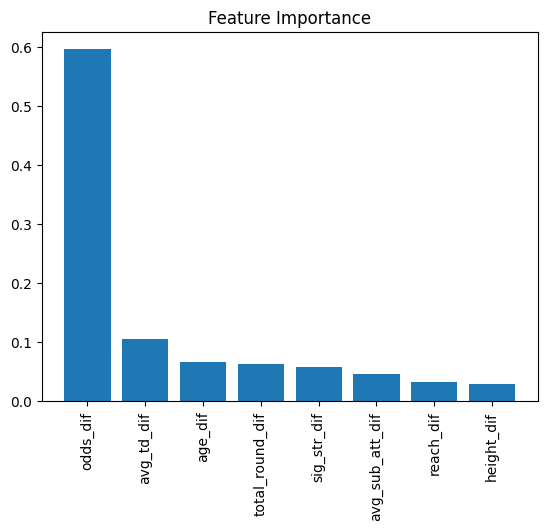

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[189 212]
 [146 432]]


# LOGISTIC REGRESSION (TUNED)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

lr = LogisticRegression()

# define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.05, 0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 1000, 10000]
}

# create grid search object
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, n_jobs=-1)

# fit grid search object to training data
grid_search.fit(X_train_scaled, y_train)

# print best parameters and accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Accuracy: ", grid_search.best_score_)

Best parameters:  {'C': 0.05, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy:  0.6542343024166187


/Users/mzheng/univ4697/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
360 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mzheng/univ4697/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mzheng/univ4697/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/mzheng/univ4697/venv/lib/python3.10/site-packages/sklearn/linear_model/_logisti

In [35]:
best_parameters = {'C': 0.05, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

lr = LogisticRegression(**best_parameters)

# fit model to training data
lr.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = lr.predict(X_test_scaled)

# calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)

# print accuracy of model on test data
print("Accuracy: ", accuracy)

Accuracy:  0.6424923391215526


# GRADIENT BOOSTING MACHINE (TUNED)

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

# define GBM model and hyperparameters
gbm = GradientBoostingClassifier(random_state=12345)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
}

# perform grid search to find best hyperparameters
grid_search = GridSearchCV(gbm, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# print the best hyperparameters and accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: ", accuracy)

Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy score:  0.6496424923391215


# Part 4: CONCLUSION

* Betting Odds Accuracy = 64.93%
* Best Model Accuracy (Gradient Boosting Machine - Tuned) = 64.96%

It is reasonable to conclude that a machine learning model is as accurate or more accurate than using betting odds to predict MMA outcomes.